# Laboratorio de filtrado óptimo - Groupo 1 ITBA

### Alumnos
### Matías Larroque
### Nicolás de León

#### Imports

In [1]:
import os
import numpy as np
from IPython.display import Audio, clear_output
from scipy import signal
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, inv
from scipy.interpolate import interp1d
import pandas as pd
from scipy.signal import stft
import librosa
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
csv_path = "out.csv"
csv_import = True
keys_signals = ["voice", "music", "linear", "square", "exponential", "whitenoise"]
if csv_import and os.path.exists(csv_path):
  last_data = pd.read_csv(csv_path)
  for key in keys_signals:
    with open(f'{key}_filters.pickle', 'wb') as handle_0:
        pickle.dump(last_data[key][0], handle_0, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'{key}_results.pickle', 'wb') as handle_1:
        pickle.dump(last_data[key][1], handle_1, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'{key}_estimations.pickle', 'wb') as handle_2:
        pickle.dump(last_data[key][2], handle_2, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'succesfully dump {key}')
    


#### Generación de señales de prueba

Se desea generar 6 señales distintas para probar el comportamiento del sistema.
Una de ellas corresponde a una señal de música, otra es una señal de voz, mientras que también se utilizarán una señal cuadrada de 100Hz, un barrido lineal en frecuencia (o sweep), un barrido exponencial y ruido blanco gaussiano de media cero. 

In [3]:
if not os.path.exists('oasis-cast-no-shadow.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/oasis-cast-no-shadow.wav"

if not os.path.exists('ImJusHanginWitDaBoyz.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/ImJusHanginWitDaBoyz.wav"

clear_output()

In [4]:
def square2audio(N=44100, fs=44100, fo=100, clip_factor=1):
  t = np.linspace(0, int(N/fs), N)
  output = signal.square(2 * np.pi * fo * t)*(clip_factor) 
  return t, output

def lineal_sweep2audio(N=44100, fs=44100, f0=20, f1=20000, T=1):
  t = np.linspace(0, int(N/fs), N)
  k = (f1-f0)/T
  output = np.sin(2*np.pi*f0*t + 2*np.pi*k*(t**2)/2)
  return t, output

def exp_sweep2audio(N=44100, fs=44100, f0=20, f1=20000, T=1):
  t = np.linspace(0, int(N/fs), N)
  k = (f1/f0)**(1/T)
  K = np.array([k**i for i in t])
  output = np.sin(2*np.pi*f0*(K - 1)/np.log(k))
  return t, output

def white_gaussian2audio(N=44100, fs=44100, sigma=0.3):
  t = np.linspace(0, int(N/fs), N)
  output = np.random.normal(0, sigma, N)
  return t, output

def file_audio(file='oasis-cast-no-shadow.wav', fs=44100, crop=1, norm=True, mono=True):
  fs, audio = scipy.io.wavfile.read(file)
  assert fs == fs
  
  t = np.arange(0, 1, 1/fs)
  
  if mono and audio.shape[1] == 2:
    mono = np.array(audio[:][0])
    mono = (audio[:, 0] + audio[:, 1]) / 2
    audio = mono
  
  if norm:
    audio = np.interp(audio, (audio.min(), audio.max()), (-1, 1))
  
  return t, audio[:crop*fs]


# Señales u(n) - Output del parlante

## Square Out

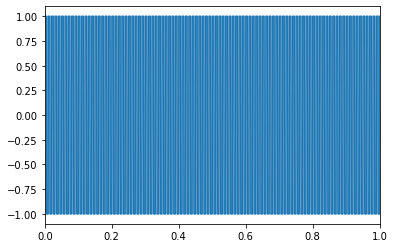

In [5]:
plt.figure()
t, out = square2audio(N=44100*3)
plt.plot(t, out)
plt.xlim(0, 1)
Audio(out, rate=44100)

## Lineal Out

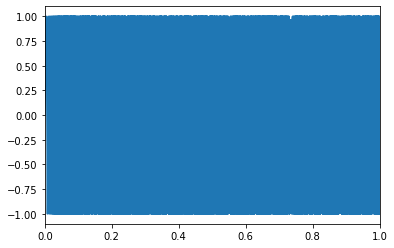

In [6]:
plt.figure()
t, out = lineal_sweep2audio()
plt.plot(t, out)
plt.xlim(0, 1)
Audio(out, rate=44100)

## Exponential Out

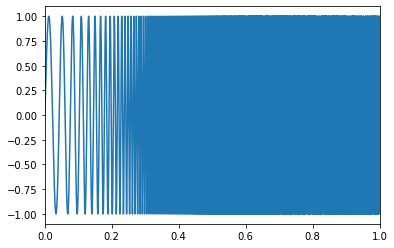

In [7]:
plt.figure()
t, out = exp_sweep2audio()
plt.plot(t, out)
plt.xlim(0, 1)
Audio(out, rate=44100)

## White Noice Out

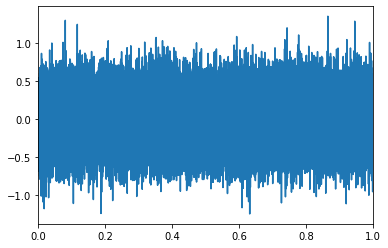

In [8]:
plt.figure()
t, out = white_gaussian2audio()
plt.plot(t, out)
plt.xlim(0, 1)
Audio(out, rate=44100)

## Music Out

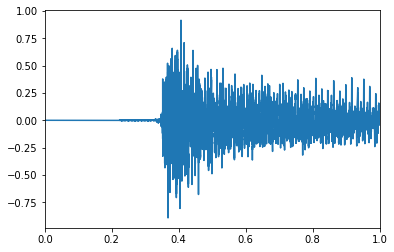

In [9]:
plt.figure()
t, out = file_audio()
plt.plot(t, out)
plt.xlim(0, 1)
Audio(out, rate=44100)

## Voice Out

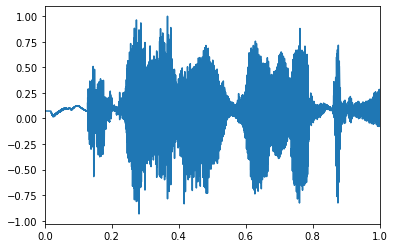

In [10]:
plt.figure()
t, out = file_audio(file='ImJusHanginWitDaBoyz.wav')
plt.plot(t, out)
plt.xlim(0, 1)
Audio(out, rate=44100)

# Señales de Audio Recibidas por el Micrófono (señales d(n))

In [11]:
if not os.path.exists('music-in.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/music-in.wav"

if not os.path.exists('voice-in.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/voice-in.wav"

if not os.path.exists('square3s.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/square3s.wav"

if not os.path.exists('linealv2.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/linealv2.wav"

if not os.path.exists('expo-in.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/expo-in.wav"

if not os.path.exists('whitenoise3s.wav'):
  !wget "https://raw.githubusercontent.com/nicolasdeleon/optimal-filtering/master/whitenoise3s.wav"

clear_output()

### Guardemos visualizamos y escuchamos los audios

Debemos visualizar las señales a lo largo el tiempo, para percibir si hubo alguna respuesta perceptible a simple vista de parte del sistema parlante-habitación-micrófono. Además, debemos procurar "alinear" las señales de salida del parlante con las de la entrada del micrófono, teniendo en cuenta que se comenzó a grabar la repuesta del sistema, momentos antes de que se comienze a reproducir el sonido por el parlante, por ende, se debe alinear la muestra inicial de la señal del parlante u(n), con la inicial de la señal d(n) que es la respuesta al sistema.

In [12]:
def pre_process_signal(o):
    # normalise the values (zscore)
    o = (o - np.mean(o)) / np.std(o)
    # take any values > 2 standard deviations
    o = np.where(o > 2, 1.0, 0.0)
    
    # add an 'decay' to the values such that we can do a more 'fuzzy' match
    # forward pass
    for i in range(1, len(o)):
        o[i] = max(o[i], o[i-1] * 0.9)
        
    # backwards pass
    for i in range(len(o)-2, 0, -1):
        o[i] = max(o[i], o[i+1] * 0.9)
    return o

def MSE(x1, x2):
  return np.mean((abs(np.array(x1)) - abs(np.array(x2)))**2)

def align_audio_data(s1, s2, min_shift_samples=5000):
  """
  align_audio_data: 
    return the output signal (recording_data), aligned with the samples of the input signal (talking_data), discarding
    the samples that corresponds with no correlation.
  """
  g1 = np.gradient(np.gradient(s1))
  g2 = np.gradient(np.gradient(s2))
  x1 = pre_process_signal(g1)
  x2 = pre_process_signal(g2) 
  N = len(x1)
  if N < min_shift_samples:
    min_shift_samples = int(N/20)


  shifts = np.arange(min_shift_samples, len(x2) - N + 1, 10)

  errors = [MSE(x1, x2[s:s+N]) for s in shifts]
  delta = shifts[np.argmin(errors)]
  return s2[delta:delta+N]
  


def probe_align_function(x, y, title):
  aligned = align_audio_data(x, y)
  fig, axes = plt.subplots(3,1)
  fig.suptitle(title)
  axes[0].set_ylabel("micorofno")
  axes[0].plot(y[0:len(x)])
  axes[1].set_ylabel("parlante")
  axes[1].plot(np.array(x))
  axes[2].set_ylabel("alineadas")
  axes[2].plot(aligned)
  return aligned



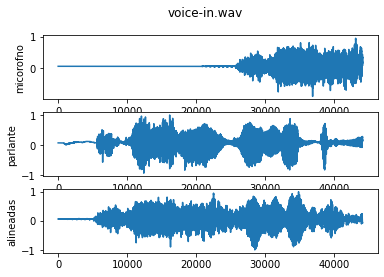

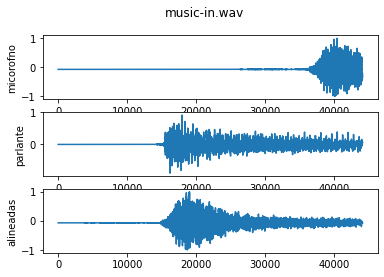

In [13]:
def get_udata_ddata(talking_data, record_data_name):
  fs, music_rec = scipy.io.wavfile.read(record_data_name)
  rec_norm = np.interp(music_rec, (music_rec.min(), music_rec.max()), (-1, +1))
  rec_aligned = probe_align_function(talking_data, rec_norm, record_data_name)
  return talking_data, rec_aligned

rec_al, desired_sound = get_udata_ddata(file_audio(file='ImJusHanginWitDaBoyz.wav')[1], 'voice-in.wav')
rec_al, desired_sound = get_udata_ddata(file_audio()[1], 'music-in.wav')


In [14]:
fs, music_rec = scipy.io.wavfile.read('music-in.wav')
fs, voice_rec = scipy.io.wavfile.read('voice-in.wav')
fs, square_rec = scipy.io.wavfile.read('square3s.wav')
fs, linear_rec = scipy.io.wavfile.read('linealv2.wav')
fs, exponential_rec = scipy.io.wavfile.read('expo-in.wav')
fs, whitenoise_rec = scipy.io.wavfile.read('whitenoise3s.wav')
t, to_talking = file_audio(file='ImJusHanginWitDaBoyz.wav')

voice_rec = voice_rec[int(0.2*fs):]
voice_rec_al = align_audio_data(to_talking, np.interp(voice_rec, (voice_rec.min(), voice_rec.max()), (-1, +1)))

t, to_talking = file_audio()
music_rec = music_rec[int(0.2*fs):]
music_rec_al = align_audio_data(to_talking, np.interp(music_rec, (music_rec.min(), music_rec.max()), (-1, +1)))

square_rec_al = align_audio_data(
    square2audio()[1], np.interp(square_rec[int(0.8*fs):int(2*fs)], (square_rec.min(), square_rec.max()), (-1, +1))
    )

exponential_rec_al = align_audio_data(
    exp_sweep2audio()[1], np.interp(exponential_rec[int(0.4*fs):], (exponential_rec.min(), exponential_rec.max()), (-1, +1))
    )


linear_rec = np.array([track[0] for track in linear_rec]) [int(1.05*fs):int(2.05*fs)+1]
linear_rec_al = np.interp(linear_rec, (linear_rec.min(), linear_rec.max()), (-1, +1))


whitenoise_rec_al = align_audio_data(
    white_gaussian2audio()[1], np.interp(whitenoise_rec[int(0.8*fs):int(2.5*fs)], (whitenoise_rec.min(), whitenoise_rec.max()), (-1, +1))
)

input_audio_sample_rate = fs

desired_signals = {
    'music': music_rec_al,
    'voice': voice_rec_al,
    'square': square_rec_al,
    'linear': linear_rec_al,
    'exponential': exponential_rec_al,
    'whitenoise': whitenoise_rec_al,
}

u_signals = {
    'music':file_audio()[1] ,
    'voice': file_audio(file='ImJusHanginWitDaBoyz.wav')[1],
    'square': square2audio()[1],
    'linear': lineal_sweep2audio()[1],
    'exponential': exp_sweep2audio()[1],
    'whitenoise': white_gaussian2audio()[1],
}

for value in desired_signals:
  try:
    assert len(desired_signals[value]) == 44100
  except AssertionError:
    print(f'Error: track {value} length != 44100')

### Contraste de los audios de Voz

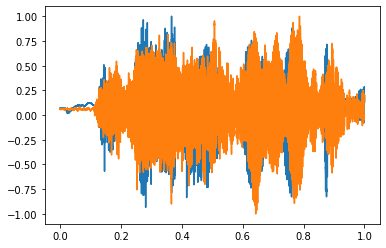

In [15]:
from IPython.display import Audio

t = np.arange(0, 1, 1/fs)
t2, out = file_audio(file='ImJusHanginWitDaBoyz.wav')

plt.plot(t2, out)
plt.plot(t, desired_signals['voice'])

Audio(desired_signals['voice'], rate=fs)

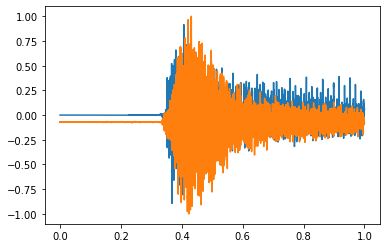

In [16]:
t = np.arange(0, 1, 1/fs)
t2, out = file_audio()

plt.plot(t2, out)
plt.plot(t, desired_signals['music'])

Audio(desired_signals['music'], rate=fs)

### Contraste de los audios Cuadrada

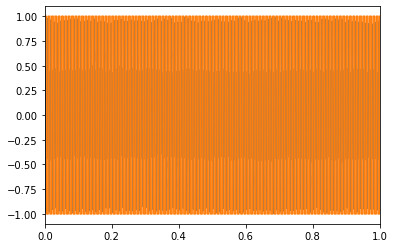

In [17]:
t = np.arange(0, 1, 1/fs)
plt.plot(t, desired_signals['square'])
t2, out = square2audio()
plt.plot(t2, out)
plt.xlim(0, 1)
Audio(desired_signals['square'], rate=fs)


### Contraste de los audios lineal sweep

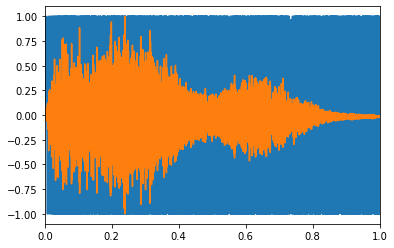

In [18]:
t = np.arange(0, 1, 1/fs)
t2, out = lineal_sweep2audio()
plt.plot(t2, out)
plt.plot(t, desired_signals['linear'])
plt.xlim(0, 1)
# desired_signals['linear']
Audio(desired_signals['linear'], rate=fs)

### Contraste Ruido Blanco

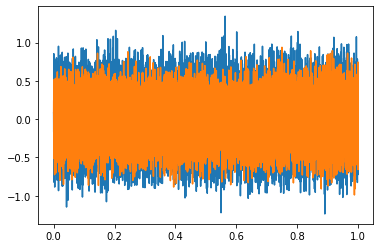

In [19]:
t = np.arange(0, 1, 1/fs)
t2, out = white_gaussian2audio()
plt.plot(t2, out)
plt.plot(t, desired_signals['whitenoise'])
Audio(desired_signals['whitenoise'], rate=fs)

### Contraste Exponencial

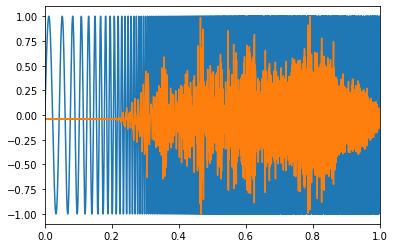

In [20]:
t = np.arange(0, 1, 1/fs)
t2, out = exp_sweep2audio()
plt.plot(t2, out)
plt.plot(t, desired_signals['exponential'])
plt.xlim(0., 1)
Audio(desired_signals['exponential'], rate=fs)

# Filtro Óptimo Wiener

Teniendo en cuenta las señales deseadas $ d(n) $ y las entradas $ u(n) $

1. Calculamos la matriz de autocorrelación $ R $, el vector de correlación cruzada $ P $ y la estimación de la varianza de la señal deseada $ \sigma^2_{\hat{d}} $

2. Realizamos el filtro $ Wo $ y calculamos la $ J_{min} $ para ciertos $ M $
 
3. Graficamos los $ J_{min} $ para todos los filtros, es decir todos los $ M $

4. Quedarse con el filtro del $ M $ óptimo, es decir, que minimice $ J_{min} $ significativamente respecto de otros valores de M

## Ecuaciones útiles

Ecuación de Wiener-Hopf

$$ {\sum_{i=0}^{\infty}} W_{oi} E[u(n-k)u^*(n-i)] = E[u(n-k)d^*(n)], k = 0,1,2...M $$


Puede interpretarse como la autocorrelación de $ u(n) $ con retardo $ (i-k) $:

$$ r(i-k) = E[u(n-k)u^*(n-i)] $$

Matriz de autocorrelación $ R $ del vector $ u(n) $:

$$ R = \begin{bmatrix}
r(0) & r(1) & ... & r(M-1) \\
r^*(1) & r(0) & ... & r(M-2) \\
. & . & ... & . \\
. & . & ... & . \\
r^*(M-1) & r^*(M-2) & ... & r(0)
\end{bmatrix} $$

Puede interpretarse como la correlación cruzada entre la entrada $ u(n-k) $ y la seal deseada $ d(n) $:

$$  p(-k) = E[u(n-k)d^*(n)] $$

podemos definir asi el vector  $ P = E[u(n)d^*(n)] $:

$$ P = [p(0), p(-1), ..., p(1 - M)]^T $$

Estimacion de la varianza

$$ \sigma^2_{\hat{d}} = p^H W_0 = p^HR^{-1}p $$

Varianza de la señal deseada $ \sigma^2_d $ entonces

$$ J_{min} = \sigma^2_d - \sigma^2_{\hat{d}} $$ 

Error cuadrático medio normalizado:

$$ \varepsilon = 1 - \frac{\sigma^2_d}{\sigma^2_{\hat{d}}} $$ 

In [21]:
def get_p_r_inv_corr_method(u, d, M, r_inv=True):
  """
  get_p_r_inv_corr_method:
    recibe la señal de entrada, la deseada y la cantidad de coeficientes "M" del filtro de Wiener
    mediante las identidades vectoriales de Wiener-Hopf halla P y la inversa de R.
  """
  r_full = np.correlate(u, u, 'full')
  r_full = r_full / len(r_full)
  r = r_full[int(len(r_full) / 2):-1]
  p_full = np.correlate(u, d, 'full')
  p_full = p_full / len(p_full)
  p = np.flip(p_full[0:int(len(r_full) / 2)])
  if r_inv:
    R = inv(toeplitz(r[0:M]))
  else:
    R = toeplitz(r[0:M])
  return p[0:M], R


def Jmin_epsilon(d, p, Wo):
  """
  Jmin_epsilon:
    recibe la señal deseada, el vector P de Wiener Hopf y los coeficientes óptimos del filtro de Wiener
    devuelve Jmin y el epsilon para esa estimación.
  """
  r_d = np.correlate(d, d, 'full')
  r_d = r_d / len(r_d)
  sigma_d = r_d[int(len(r_d) / 2)]
  sigma_y = np.dot(p, Wo)
  return (sigma_d - sigma_y), (1 - (sigma_y / sigma_d))


def generate_J_filter(d, u, Ms, early_stopping=0.01):
  """
  generate_J_filter:
    recibe la señal deseada, la señal de entrada al filtro, un vector con cantidades de coeficientes de los filtros
    de Wiener, y tambien un factor de early_stopping para dejar de procesar en caso de no lograr mejora significativa en Jmin aumentando M.
    La función calcula coeficientes del filtro de Wiener según las cantidades del vector "Ms", entonces devuelve Jmin, epsilon y los coeficientes
    para cada valor de cantidad de coeficientes...
    Vale aclarar que el criterio de early stopping por default es que no haya una mejora de un 1% en el error cuadrático medio mínimo
  """
  js = []
  epsilons = []
  Ws = []
  i = 0
  for m in Ms:
    p_, Rinv_ = get_p_r_inv_corr_method(u, d, m)
    Wo = np.dot(Rinv_, p_)
    jmin, epsilon = Jmin_epsilon(d, p_, Wo)
    if (len(epsilons) > 1) and abs(epsilon - epsilons[-1]) < (epsilons[-1] * early_stopping):
      return js, epsilons, Ws
    else:
      js.append(jmin)
      epsilons.append(epsilon)
      Ws.append(Wo)
  return js, epsilons, Ws


### Estimación de Filtros Óptimo en función de M:número de coeficientes.

Una vez que se tienen las funciones definidas, se implementa el algoritmo como se muestra a continuación, guardando los resultados de manera conveniente...

In [22]:
Ms = [100, 500, 700, 900, 1100, 1500, 1900, 2400, 2800, 3200, 3800, 4400, 5000, 5600, 6000, 7000]

keys_signals = ["voice", "music", "linear", "square", "exponential", "whitenoise"]
J_dict = {}
epsilon_dict = {}
W_dict = {}

cache = True

for key in keys_signals:
    if cache and os.path.exists(f'{key}_filters.pickle'):
        # If cache and file exists then load it
        with open(f'{key}_filters.pickle', 'rb') as handle:
            data = pickle.load(handle)
            J_dict[key] = data['Js']
            epsilon_dict[key] = data['epsilons']
            W_dict[key] = data['Ws']
    else:
        # If not cache or file doesn't exists then calculate
        j, eps, w = generate_J_filter(desired_signals[key], u_signals[key], Ms, early_stopping=0)
        if cache:
            # If cache then store
            with open(f'{key}_filters.pickle', 'wb') as handle:
                dic = {
                  'Js': j,
                  'epsilons': eps,
                   'Ws': w
                }
                pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
        J_dict[key] = j
        epsilon_dict[key] = eps
        W_dict[key] = w


### Muestra de resultados
A continuación se definen funciones para poder apreciar los resultados obtenidos al aplicar el algoritmo con las ecuaciones de Wiener Hopfman.

In [23]:
def find_best(epsilons, early_stopping=0.01):
  """
  find_best:
    dado una metrica (que por defecto tiene nombre "epsilon"), busca el índice
    que tiene la mínima métrica y que además cumple con el earling stopping. Retorna el índice encontrado.
    Si no se cumple el early stopping, solo devuelve el último elemento. Asume que el vector de métricas
    está ordenado de forma descendente.
  """
  best_index = len(epsilons) - 1
  for i in range(len(epsilons) - 1):
    if abs(epsilons[i + 1] - epsilons[i]) < (epsilons[i] * early_stopping):
      return i

  return best_index


def metric_vs_M(Ms, metric):
  """
  metric_vs_M:
    genera los ejes horizontal y vertical para graficar en un plano.
  """
  metric_interp = interp1d(Ms, metric, fill_value="extrapolate")
  m_x = np.linspace(np.min(Ms), np.max(Ms), 2000)
  return m_x, metric_interp(m_x)


def graph_metrics(Ms, js, epsilons, title, stop_jmin=0.03, stop_epsilon=0.01):
  """
  graph_metrics: 
    grafica Jmin y epsilon. Se le pasa el early stopping de cada métrica ya que llama a find_best para 
    marcar el índice que devuelve dicha función en el gráfico.
  """
  fig, axes = plt.subplots(1, 2, figsize=(15,5))
  axes[0].set_ylabel("jmin")
  x0, y0 = metric_vs_M(Ms, js)
  axes[0].plot(x0, y0)
  axes[0].axvline(Ms[find_best(js, stop_jmin)], color='red')
  axes[0].grid(b=True)
  axes[1].set_ylabel("epsilon")
  x1, y1 = metric_vs_M(Ms, epsilons)
  axes[1].plot(x1, y1)
  axes[1].axvline(Ms[find_best(epsilons, stop_epsilon)], color='red')
  axes[1].grid(b=True)
  fig.suptitle(title)


Se decide utilizar otro ciclo 'for' para separar los cálculos de los gráficos, y de la elección de resultado, en lugar de agrupar todo en un solo ciclo.

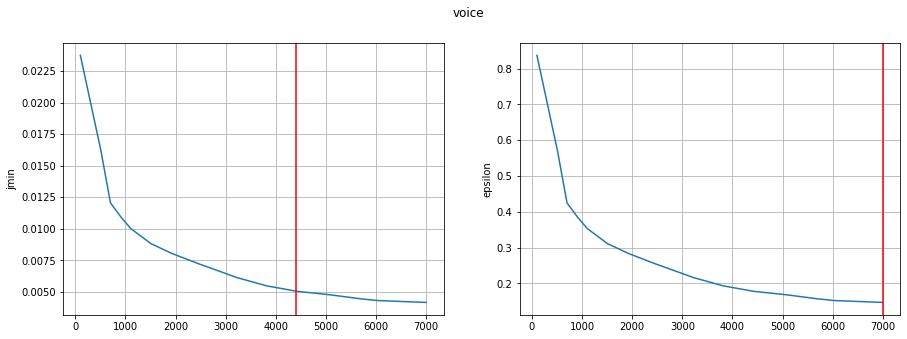

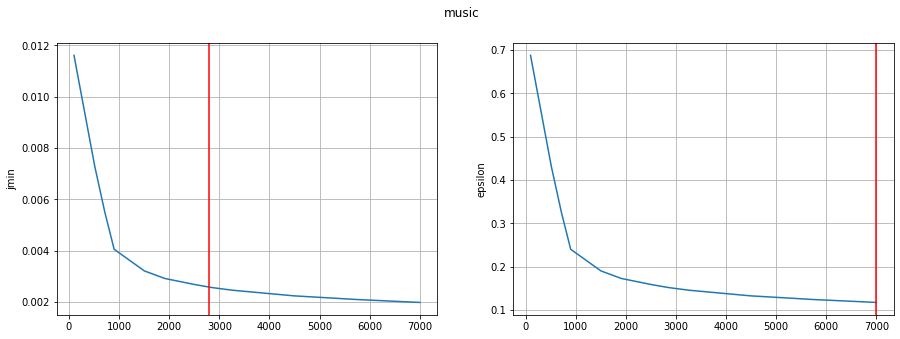

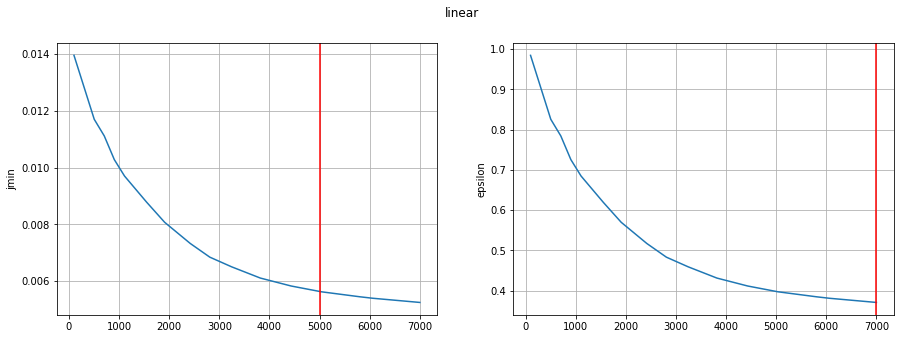

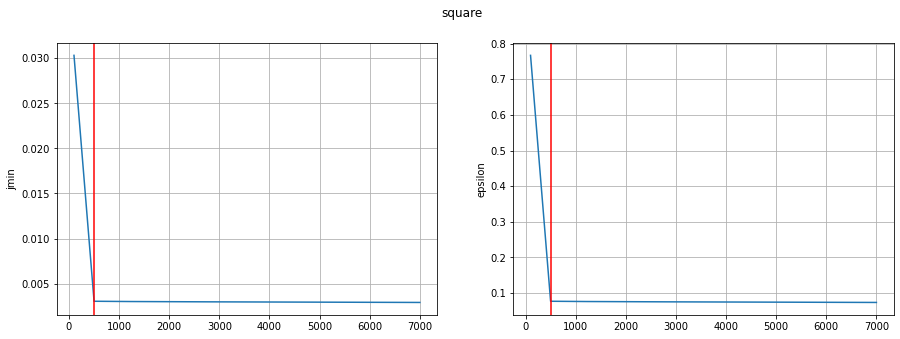

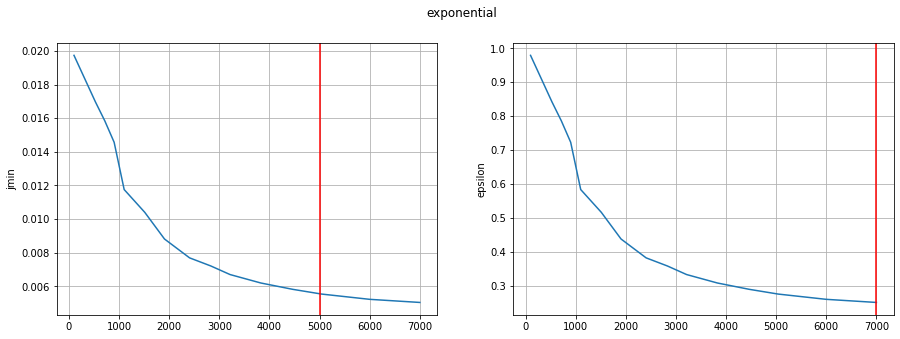

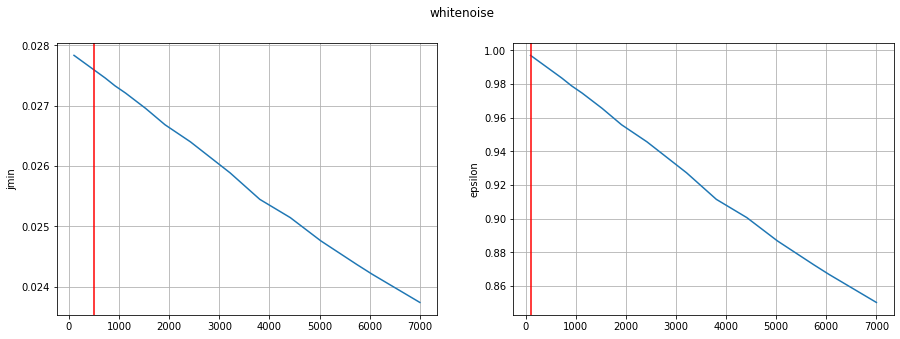

In [24]:
early_stop_dict = {'voice': 0.05, 'music':0.05 , 'linear': 0.03, 'square':0.05, 'exponential':0.05, 'whitenoise': 0.005}
for key in keys_signals:  
  graph_metrics(Ms[0:len(np.array(J_dict[key]))], J_dict[key], epsilon_dict[key], key, early_stop_dict[key])
  

### Elección de M
Se elige la cantidad de coeficientes del filtro cuando al aumentar M no se tiene una disminución de $J_{min}$ lo suficientemente significativa. Esto se puede expresar en porcentaje con el concepto de "early stopping". Si la métrica ($J_{min}$) no disminuye un `early_stopping` % al incrementar un paso de M, entonces se cesa de incrementar la cantidad de coeficientes.
Por otro lado, es importante aclarar que se fijo un valor de M máximo debido al orden cúbico del algortimo.

In [25]:
M_dict = {}
results_dict = {}

eig_dict = {}

cache = True

for key in keys_signals:
  if cache and os.path.exists(f'{key}_results.pickle'):
        # If cache and file exists then load it
        with open(f'{key}_results.pickle', 'rb') as handle:
            data = pickle.load(handle)
            results_dict[key] = data['results']
            eig_dict[key] = data['avas_aves']

  else:
    index = find_best(J_dict[key], early_stop_dict[key])
    M_dict[key] = [index, Ms[index]]
    P, R = get_p_r_inv_corr_method(u_signals[key], desired_signals[key], M_dict[key][1], r_inv=False)
    Jmin_choosen, epsilon_choosen = Jmin_epsilon(desired_signals[key], P, W_dict[key][index])
    results_dict[key] = [M_dict[key][1], Jmin_choosen, epsilon_choosen, index]

    avas, aves = np.linalg.eig(R)
    avas = np.sort(avas)
    eig_dict[key] = [avas, aves]
    if cache:
              # If cache then store
              with open(f'{key}_results.pickle', 'wb') as handle:
                  dic = {
                    'results': results_dict[key],
                    'avas_aves': eig_dict[key],
                  }
                  pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
  

df_results = pd.DataFrame.from_dict(results_dict, orient='index', columns=['M', 'Jmin', 'epsilon', 'index_M'])
df_results

,M,Jmin,epsilon,index_M
voice,4400,0.005050,0.178005,11
music,2800,0.002578,0.152753,8
linear,5000,0.005637,0.397578,12
square,500,0.003049,0.077152,1
exponential,5000,0.005558,0.275776,12
whitenoise,500,0.027592,0.988292,1


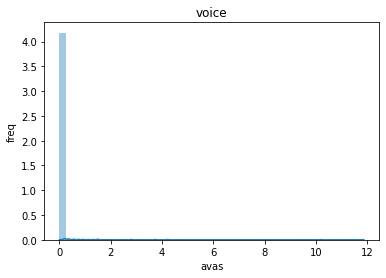

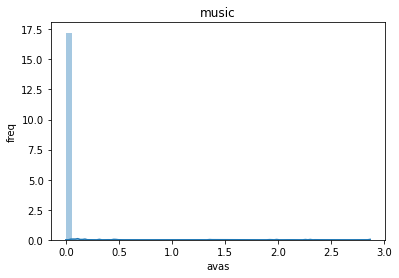

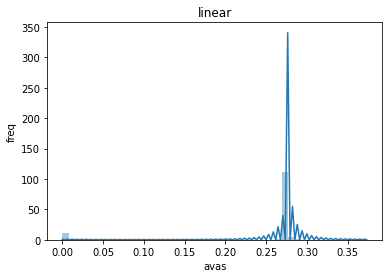

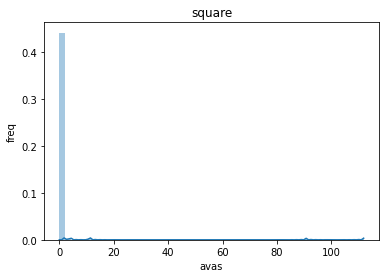

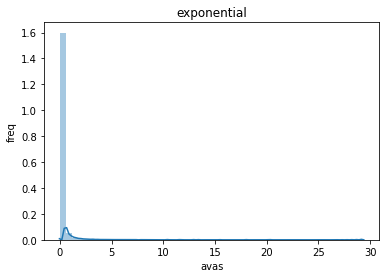

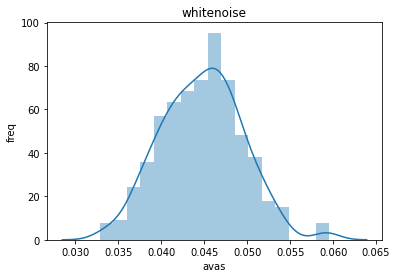

In [26]:
for key in keys_signals:
  plt.figure()
  plt.title(key)
  plt.ylabel("freq")
  plt.xlabel("avas")
  sns.distplot(abs(eig_dict[key][0]), norm_hist = True)


### Distribución de Autovalores

Se puede observar que la distribución de los autovalores esta concentrada, en todos los modelos, si se descartan algunos "outliers". Además los valores son pequeños, lo que es indicio de que el modelo se encuentra próximo a ser el óptimo, en la mayoría de sus componentes.

# Resultados y elección del modelo
## Análisis sobre resultados y elección


Entonces, una vez seleccionada la entrada que se utiliza para generar el modelo (obtener los coeficientes), se procede a estimar la salida $y(n)$ y escuchar la misma (con auriculares para apreciar frecuencias que algunos parlantes de PC no logran reproducir) esperando que se identifique la correspondencia con la señal deseada, es decir, como si hubiera pasado por el sistema parlante-habitación-micrófono.

Vale aclarar que se estimaron las respuestas a las 6 señales de excitación que se utilizaron a lo largo de este artículo.

Luego de realizar esto para los 6 modelos se obtuvó el mejor resultado cualitativo y empírico al escuchar el audio filtrado para aquel modelo cuyos coeficientes se calcularon a partir de la señal sweep lineal. Además de esto, este modelo también presenta los parámetros M y $ J_{min} $ aceptables.

In [27]:
model_choosen = "linear"
W_model = W_dict[model_choosen][results_dict[model_choosen][3]]

cache = True

y_signals = {}
for key in keys_signals:
  if cache and os.path.exists(f'{key}_estimations.pickle'):
        # If cache and file exists then load it
        with open(f'{key}_estimations.pickle', 'rb') as handle:
            data = pickle.load(handle)
            y_signals[key] = data['y']
  else:
    y_signals[key] = scipy.signal.filtfilt(W_model, [1], u_signals[key])
    if cache:
          # If cache then store
          with open(f'{key}_estimations.pickle', 'wb') as handle:
              dic = {'y': y_signals[key]}
              pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Audio Filtrado

Procedimos entonces con el filtro seleccionado a filtrar un audio de varios segundos de música

In [28]:
fs, audio = scipy.io.wavfile.read('oasis-cast-no-shadow.wav')
audio = np.array([track[0] for track in audio])
Audio(audio, rate=fs)

In [29]:
audio_in_room = signal.filtfilt(W_model, [1], audio)
Audio(audio_in_room, rate=fs)

Estando en la sala se puede percibir que el primer sonido tiene semejanzas con el segundo audio (escuchado con auriculares).

In [30]:
dic_final_data = {}
for key in keys_signals:
   with open(f'{key}_filters.pickle', 'rb') as handle_filters:
      data_filter = pickle.load(handle_filters)
   with open(f'{key}_results.pickle', 'rb') as handle_results:
      data_results = pickle.load(handle_results)
   with open(f'{key}_estimations.pickle', 'rb') as handle_estimations:
      data_estimations = pickle.load(handle_estimations)
   dic_final_data[key] = [data_filter, data_results, data_estimations]

final_df = pd.DataFrame.from_dict(dic_final_data)
final_df.to_csv(csv_path)
aux = pd.read_csv(csv_path)
aux["voice"]

0    {'Js': [0.02375364270263064, 0.016411220630445...
1    {'results': [4400, 0.0050502460951163015, 0.17...
2    {'y': array([0.04304455, 0.04307624, 0.0431060...
Name: voice, dtype: object